# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [2]:
torch.cuda.empty_cache()

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1

#UNK - "unknown token", EOS - "end of sentence",BOS - "beginning of sentence"



def vocabular_set(counter_threshold, words):
    
    vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
    for char, cnt in words.items():
        if cnt > counter_threshold:
            vocab.add(char)

    print(f'Размер словаря: {len(vocab)}')

    word2ind = {char: i for i, char in enumerate(vocab)}
    ind2word = {i: char for char, i in word2ind.items()}
    return word2ind, ind2word, vocab


  0%|          | 0/120000 [00:00<?, ?it/s]

In [7]:
counter_threshold = 15
word2ind, ind2word, vocab = vocabular_set(counter_threshold, words)

Размер словаря: 15764


In [8]:
class WordDataset:
    def __init__(self, sentences, word2ind):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

## Train loop

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [10]:
def plot_losses_types(losses_type):
    for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
        plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

    plt.title('Losses')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

def plot_accuracy_types(losses_type, acc_type):
    for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
        plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
        print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

    plt.title('Accuracy')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

## Архитектура модели

In [12]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, dropout_rate = 0.1, num_layers:int = 1, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [11]:
def train_loop(model, eval_steps, num_epoch, train_dataloader, eval_dataloader, criterion, optimizer):

    losses = []
    acc = []

    for epoch in range(num_epoch):
        epoch_losses = []
        epoch_acc = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                epoch_acc.append(evaluate(model, eval_dataloader))
                model.train()
        acc.append(sum(epoch_acc) / len(epoch_acc))
        losses.append(sum(epoch_losses) / len(epoch_losses))
 
    return losses, acc

In [15]:
counter_threshold = 25

word2ind, ind2word, vocab = vocabular_set(counter_threshold, words)
train_dataset = WordDataset(dataset['train'], word2ind)

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx), word2ind)

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

Размер словаря: 11842


In [11]:
torch.cuda.is_available()

True

In [17]:
#ВЫБОР ГИПЕР-ПАРАМЕТРОВ
aggregation_types = ['max', 'mean']
num_epoch = 5
eval_steps = len(train_dataloader) // 2
num_layers = 1
hidden_dim = 256
dropout_rate = 0.1

losses_type = {}
acc_type = {}
for aggregation_type in aggregation_types:
    print(f"Starting training for {aggregation_type}")

    model = CharLM(
        hidden_dim=hidden_dim, vocab_size=len(vocab), dropout_rate = dropout_rate, num_layers = num_layers, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    losses, acc = train_loop(model, eval_steps, num_epoch, train_dataloader, eval_dataloader, criterion, optimizer)
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

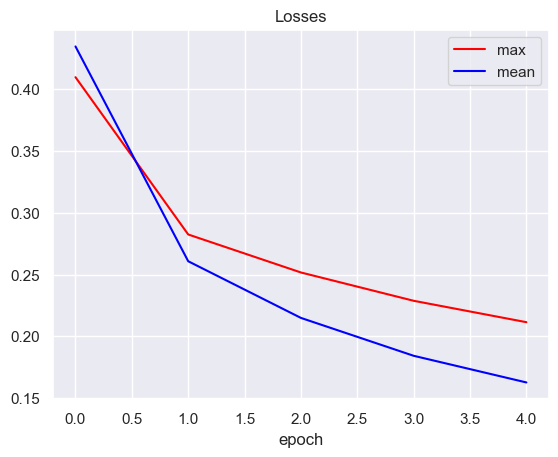

Лучшая accuracy для подхода max: 90.10
Лучшая accuracy для подхода mean: 90.63


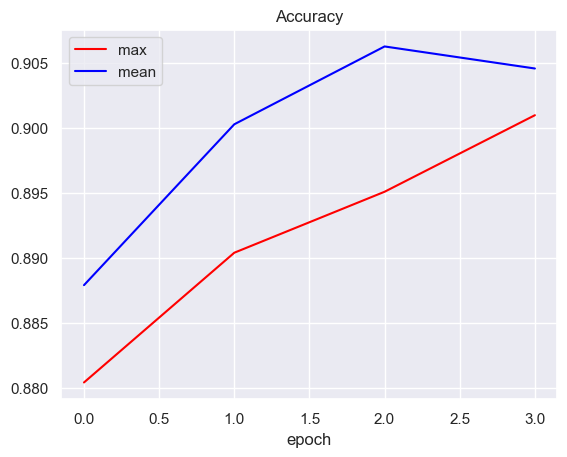

In [19]:
plot_losses_types(losses_type)
plot_accuracy_types(losses_type, acc_type)

* Первое изменение, чтобы модель заработало, оказалось простым, нужно было заменить в инициализации модели CharLM num_classes: int = 4. 'Mean' показывает лучшие значения, поэтому оставим это оптимальным параметром

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

In [12]:
def get_data(counter_threshold, words): 
    word2ind, ind2word, vocab = vocabular_set(counter_threshold, words)
    train_dataset = WordDataset(dataset['train'], word2ind)

    np.random.seed(42)
    idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
    eval_dataset = WordDataset(dataset['test'].select(idx), word2ind)

    train_dataloader = DataLoader(
        train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

    eval_dataloader = DataLoader(
        eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)
    
    return train_dataloader, eval_dataloader, word2ind, ind2word, vocab
    

In [13]:
def plot_loss_acc(losses, acc):

    plt.figsize=(10, 8)
    plt.subplot(2, 1, 1)
    # График loss_v
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # График acc_v
    plt.subplot(2, 1, 2)
    plt.plot(acc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    print('Лучшая accuracy:',round(max(acc),4) * 100)
    # Отображаем графики
    plt.tight_layout()
    plt.show()

Таким образом подбор оптимальных параметров позволило улучшить качество модели с дефолтных 90.63 до 90.73

#### Изменение RNN на LSTM или GRU

Добавим в класс CharLM параметр rnn_type

In [14]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, dropout_rate = 0.1, num_layers:int = 1, num_classes: int = 4,
        aggregation_type: str = 'max',  rnn_type: str = 'RNN'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        else:
            raise ValueError("Invalid RNN type: {}".format(rnn_type))
    
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [19]:
aggregation_type =  'mean'
num_epoch = 10
num_layers = 1
hidden_dim = 256
dropout_rate = 0.2
counter_threshold = 25
batch_size = 512
learning_rate = 0.001

train_dataloader, eval_dataloader, word2ind, ind2word, vocab = get_data(counter_threshold, words)
eval_steps = len(train_dataloader) // 2
loss_v = {}
acc_v = {}

for rrn_type in ['RNN', 'GRU', 'LSTM']:

        model = CharLM(hidden_dim=hidden_dim, vocab_size=len(vocab), dropout_rate = dropout_rate, 
                num_layers = num_layers, aggregation_type=aggregation_type, rnn_type=rrn_type).to(device)
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

        losses, acc = train_loop(model, eval_steps, num_epoch, train_dataloader, eval_dataloader, criterion, optimizer)
        loss_v[rrn_type] = losses
        acc_v[rrn_type] = acc
        del model
        torch.cuda.empty_cache()

Размер словаря: 11842


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

In [27]:
loss_v = {'RNN': [0.828295885882479,
  0.41068763327091296,
  0.33024997996523026,
  0.28934873570787145,
  0.25999781400599375,
  0.23775912136473554,
  0.21638497767296244,
  0.19793650232096935,
  0.18603406989193977,
  0.17663869578787622],
 'GRU': [0.8201997195152526,
  0.40358140633461326,
  0.3437746446817479,
  0.2841609855915638,
  0.2548546924870065,
  0.23078938145586786,
  0.21662623432088404,
  0.19853241744827718,
  0.1863684113672439,
  0.17289534937194054],
 'LSTM': [0.8655343035434154,
  0.3855899160846751,
  0.3124148110125927,
  0.2627222009795777,
  0.23636070198201117,
  0.21624832185024911,
  0.1994595394489613,
  0.18359358640427284,
  0.17195841698570455,
  0.15964632582791308]}

acc_v = {'RNN': [0.5894666512807211,
  0.8381999929745992,
  0.871399978796641,
  0.8841332991917928,
  0.8937999606132507,
  0.8991332848866781,
  0.8955333034197489,
  0.8964666326840719,
  0.8987332979838053,
  0.9001333117485046],
 'GRU': [0.6111333171526591,
  0.8499999642372131,
  0.8809999823570251,
  0.8885333140691122,
  0.890999992688497,
  0.8983333110809326,
  0.9012666344642639,
  0.8993333180745443,
  0.9029999772707621,
  0.8988666335741679],
 'LSTM': [0.5651333133379618,
  0.8513999978701273,
  0.8859999775886536,
  0.8948666453361511,
  0.8981332977612814,
  0.9013333121935526,
  0.9019999901453654,
  0.9029999772707621,
  0.9030666351318359,
  0.9027999838193258]}

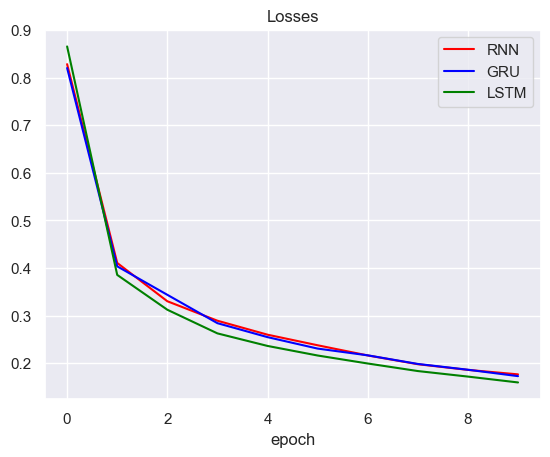

Лучшая accuracy для подхода RNN: 90.01
Лучшая accuracy для подхода GRU: 90.30
Лучшая accuracy для подхода LSTM: 90.31


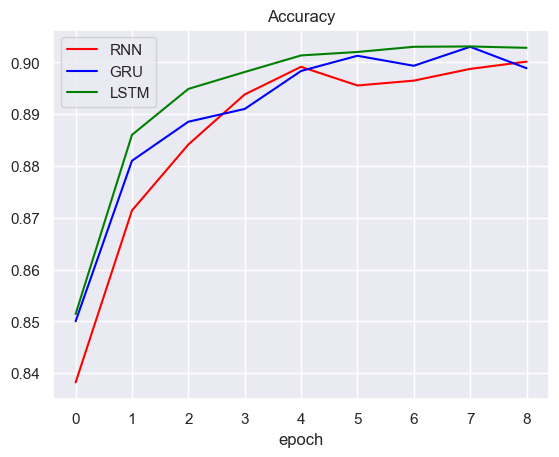

In [31]:
for (name, values), color in zip(loss_v.items(), ['red', 'blue', 'green']):
    plt.plot(np.arange(len(loss_v[name])), loss_v[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

for (name, values), color in zip(acc_v.items(), ['red', 'blue', 'green']):
    plt.plot(np.arange(len(acc_v[name][1:])), acc_v[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_v[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

Если bidirectional=False: использование LSTM показывает лучшие результаты, чем GRU

#### Изменение архитектуры после применения RNN

Перепишем класс CharLM, чтобы удобнее было менять параметры. Добавим параметры use_last_token, bidirectional

In [14]:
class CharLM_custom(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, dropout_rate=0.1, num_layers: int = 1, num_classes: int = 4,
        aggregation_type: str = 'max', rnn_type: str = 'RNN', use_last_token: bool = False, bidirectional: bool = False
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError("Invalid RNN type: {}".format(rnn_type))

        # Учитываем двунаправленность
        self.hidden_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Изменить размер линейного слоя, если используется последний токен
        if use_last_token:
            self.linear = nn.Linear(self.hidden_dim + hidden_dim, self.hidden_dim)
        else:
            self.linear = nn.Linear(self.hidden_dim, self.hidden_dim)

        self.projection = nn.Linear(self.hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type
        self.use_last_token = use_last_token
        self.bidirectional = bidirectional  # Добавить атрибут для отслеживания двунаправленности

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
 
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim * 2 (для bidirectional)]

        if self.aggregation_type == 'max':
            aggregated_output = output.max(dim=1)[0]  # [batch_size, hidden_dim * 2]
        elif self.aggregation_type == 'mean':
            aggregated_output = output.mean(dim=1)  # [batch_size, hidden_dim * 2]
        else:
            raise ValueError("Invalid aggregation_type")

        if self.use_last_token:
            last_token_embedding = embeddings[:, -1, :]  # [batch_size, hidden_dim]
            output = torch.cat([aggregated_output, last_token_embedding], dim=1)  # [batch_size, hidden_dim * 3]
        else:
            output = aggregated_output
        # Используем правильный размер для линейного слоя
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [17]:
# bidirectional=False, use_last_token=True

aggregation_type =  'mean'
num_epoch = 10
num_layers = 1
hidden_dim = 256
dropout_rate = 0.2
batch_size = 512
lr = 0.001

batch_size = 512
counter_threshold = 25

train_dataloader, eval_dataloader, word2ind, ind2word, vocab = get_data(counter_threshold, words)

eval_steps = len(train_dataloader) // 2
loss_v = {}
acc_v = {}

for i in [False, True]:

    model = CharLM_custom(
        hidden_dim=hidden_dim, vocab_size=len(vocab), dropout_rate = dropout_rate, 
            num_layers = num_layers, aggregation_type=aggregation_type, rnn_type='LSTM', 
            bidirectional=False, use_last_token=i).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    losses, acc = train_loop(model, eval_steps, num_epoch, train_dataloader, eval_dataloader, criterion, optimizer)
    loss_v[str('use_last_token: {}'.format(str(i)))] = losses
    acc_v[str('use_last_token: {}'.format(str(i)))] = acc
    del model
    torch.cuda.empty_cache()
    print('----------')

Размер словаря: 11842


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

----------


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

----------


In [22]:
loss_v = {'use_last_token: False': [0.5992720549410963,
  0.28409664567480697,
  0.22308938059401004,
  0.17639693903162124,
  0.13981014039922268,
  0.10592125581300005,
  0.08011708204099473,
  0.058259135492621586,
  0.046351468420409145,
  0.03498678382961674],
 'use_last_token: True': [0.7080161780753034,
  0.2964362193929388,
  0.22958150620156145,
  0.18861971713126974,
  0.15066702340511565,
  0.11799704809772207,
  0.09306613484278638,
  0.07148377094814118,
  0.056850518191114384,
  0.04529075525859569]}

acc_v = {'use_last_token: False': [0.6636666456858317,
  0.8900666435559591,
  0.8991999824841818,
  0.9029999772707621,
  0.9041999777158102,
  0.900933305422465,
  0.9007999698321024,
  0.897599975268046,
  0.896399974822998,
  0.8951999743779501],
 'use_last_token: True': [0.6487999856472015,
  0.8842666546503702,
  0.8987999757130941,
  0.8999999761581421,
  0.9040666619936625,
  0.9082666436831156,
  0.9099333087603251,
  0.9077999790509542,
  0.9064666430155436,
  0.907866636912028]}

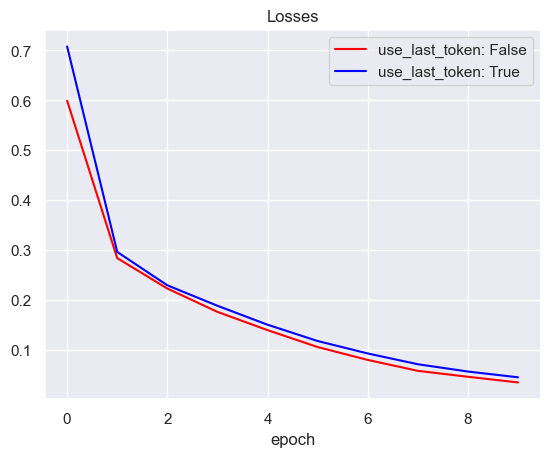

Лучшая accuracy для подхода use_last_token: False: 90.42
Лучшая accuracy для подхода use_last_token: True: 90.99


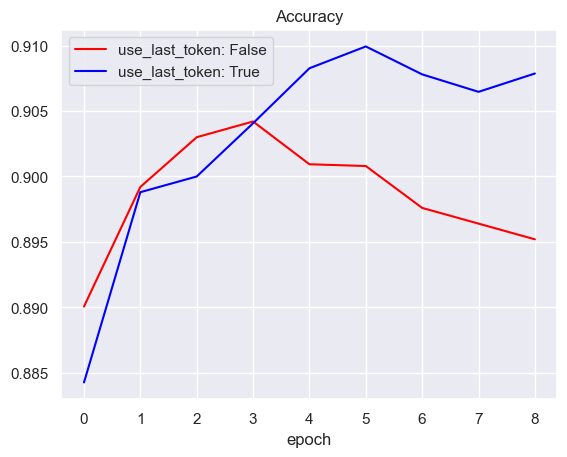

In [23]:
plot_losses_types(loss_v)
plot_accuracy_types(loss_v, acc_v)

use_last_token=True повысило точность до 91.17

In [31]:
# bidirectional=True, use_last_token=False

aggregation_type =  'mean'
num_epoch = 10
eval_steps = len(train_dataloader) // 2
num_layers = 1
hidden_dim = 128
dropout_rate = 0.2
lr = 0.001

loss_v = {}
acc_v = {}

batch_size = 512
counter_threshold = 25

train_dataloader, eval_dataloader, word2ind, ind2word, vocab = get_data(counter_threshold, words)

eval_steps = len(train_dataloader) // 2

for bidirect in [True, False]:
    for use_last in [True, False]:
        print('bidirectional: {}, use_last_token: {}'.format(str(bidirect), str(use_last)))
        model = CharLM_custom(
            hidden_dim=hidden_dim, vocab_size=len(vocab), dropout_rate = dropout_rate, 
                num_layers = num_layers, aggregation_type=aggregation_type, rnn_type='LSTM', bidirectional=bidirect, use_last_token=use_last)
        model.to(device)
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)

        losses, acc = train_loop(model, eval_steps, num_epoch, train_dataloader, eval_dataloader, criterion, optimizer)
        loss_v['bidirectional: {}, use_last_token: {}'.format(str(bidirect), str(use_last))] = losses
        acc_v['bidirectional: {}, use_last_token: {}'.format(str(bidirect), str(use_last))] = acc
        del model
        torch.cuda.empty_cache()
        print('----------')

Размер словаря: 11842
bidirectional: True, use_last_token: True


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

----------
bidirectional: True, use_last_token: False


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

----------
bidirectional: False, use_last_token: True


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

----------
bidirectional: False, use_last_token: False


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

----------


In [38]:
loss_v = {'bidirectional: True, use_last_token: True': [0.7380751221737963,
  0.3436391486766491,
  0.2694296746177876,
  0.22808370951642382,
  0.1953647272383913,
  0.16444954548744445,
  0.14090748134445638,
  0.11673354389185601,
  0.10109344942772643,
  0.07957252909211403],
 'bidirectional: True, use_last_token: False': [0.7306435009266468,
  0.33479379535989556,
  0.259579403730149,
  0.2160402347432806,
  0.17804356150804682,
  0.14924216971118398,
  0.12360268285933962,
  0.09688734532670772,
  0.07903232154376963,
  0.05913444638569304],
 'bidirectional: False, use_last_token: True': [0.8258657607626407,
  0.35911780297756196,
  0.2833055548211362,
  0.23944337526534465,
  0.2102063296323127,
  0.1832679162951226,
  0.15859854874458718,
  0.13726884687834598,
  0.12136972346838484,
  0.10524902118647352],
 'bidirectional: False, use_last_token: False': [0.7870030906606228,
  0.37045845604957417,
  0.2904898479897925,
  0.24621111718898123,
  0.21613256087962618,
  0.19008312079500644,
  0.1643383358070191,
  0.14616356625201854,
  0.12404946542166649,
  0.10812566131353378]}

In [37]:
acc_v = {'bidirectional: True, use_last_token: True': [0.6299333175023397,
  0.873533308506012,
  0.8943333029747009,
  0.9003333250681559,
  0.9035999576250712,
  0.9043999910354614,
  0.9056666493415833,
  0.9045999646186829,
  0.9014666477839152,
  0.9032666484514872],
 'bidirectional: True, use_last_token: False': [0.6383999784787496,
  0.8769999742507935,
  0.894933303197225,
  0.8988666335741679,
  0.8988666534423828,
  0.9013332923253378,
  0.9007333318392435,
  0.902733306090037,
  0.8974666396776835,
  0.8964666326840719],
 'bidirectional: False, use_last_token: True': [0.6031333307425181,
  0.8597999811172485,
  0.8851999839146932,
  0.8918666442235311,
  0.8960666457811991,
  0.899133304754893,
  0.9006666541099548,
  0.896733303864797,
  0.8989999691645304,
  0.8999333182970682],
 'bidirectional: False, use_last_token: False': [0.6105999946594238,
  0.853066643079122,
  0.884666641553243,
  0.8944666385650635,
  0.8977333108584086,
  0.9003999829292297,
  0.8969333171844482,
  0.8980666399002075,
  0.8943999608357748,
  0.8953333099683126]}

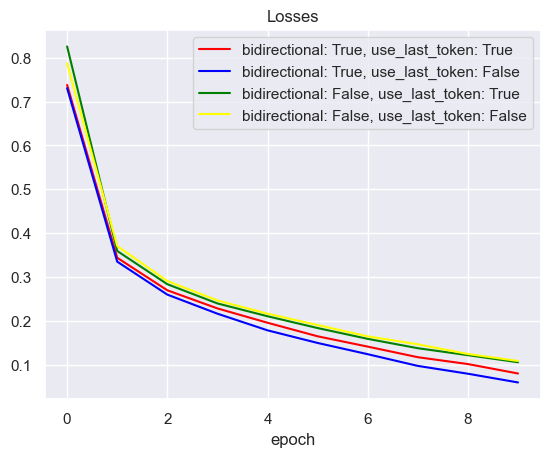

Лучшая accuracy для подхода bidirectional: True, use_last_token: True: 90.57
Лучшая accuracy для подхода bidirectional: True, use_last_token: False: 90.27
Лучшая accuracy для подхода bidirectional: False, use_last_token: True: 90.07
Лучшая accuracy для подхода bidirectional: False, use_last_token: False: 90.04


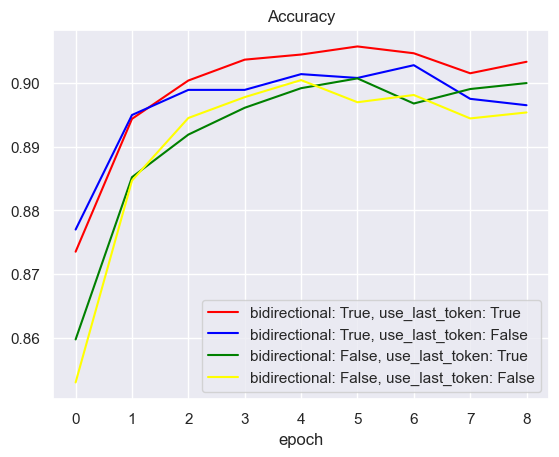

In [39]:
for (name, values), color in zip(loss_v.items(), ['red', 'blue', 'green', 'yellow']):
    plt.plot(np.arange(len(loss_v[name])), loss_v[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()


for (name, values), color in zip(loss_v.items(), ['red', 'blue', 'green', 'yellow']):
    plt.plot(np.arange(len(acc_v[name][1:])), acc_v[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_v[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучший вариант это bidirectional: True, use_last_token: True:

#### Подбор гиперпараметров и обучение до сходимости

Чтобы было удобнее проводить эксперименты перепишем код из ячеек в функции с добавлением необходимых параметров. Будем по отдельности тестировать параметры в сделующих диапазонах. 
* num_layers по дефолту = 1. Проведем поиск по list(range(1, 6))
* dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]. По дефолту стоит 0.5
* hidden_dim = [32, 64, 128, 256, 512]
* counter_threshold_arr = [15, 20, 25, 30, 35] для влияния на размер словаря
* lr = [0.1, 0.05, 0.01, 0.005, 0.001] по дефолту lr = 0.001

In [15]:
def string_to_list(string):
    # Удалите скобки и пробелы
    string = string.strip('[]').replace(' ', '')
    # Разделите строку по запятой
    return [float(x) for x in string.split(',')]

In [16]:
def save_csv(csv_name, feature_name, target, df, num_epoch, num_layers, hidden_dim, dropout_rate, acc, losses):
    results = {
        'model_params(num_epoch, num_layers, hidden_dim, dropout_rate)': [num_epoch, num_layers, hidden_dim, dropout_rate],
        feature_name: target,
        'best accuracy': round(max(acc), 3),
        'loss_v': losses,
        'acc_v': acc
    }
    new_df = pd.DataFrame([results])
    # Добавляем новую строку в DataFrame
    df = pd.concat([df, new_df], ignore_index=True)

    # Сохраняем DataFrame в CSV-файл
    df.to_csv(csv_name, index=False, columns=['model_params(num_epoch, num_layers, hidden_dim, dropout_rate)', feature_name, 'best accuracy', 'loss_v', 'acc_v'])
    return df

Для удобства все данные будет записываться в dataframe

In [17]:
def plotloss_acc_csv(path, name, y_lim_low_loss = 0, y_lim_high_loss = 1, y_lim_low_acc = 0, y_lim_high_acc = 1):
    
    df = pd.read_csv(path) 

    # Создаем фигуры и оси
    plt.figsize=(10, 8)
    plt.subplot(2, 1, 1)
    # График loss_v
    data_loss_v = df['loss_v'].apply(string_to_list)
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'olive']
    for i, feature in enumerate(df[name]):
        subset = data_loss_v[i]
        plt.plot(subset, label='{} = {}'.format(name, feature), color=colors[i % len(colors)])
    plt.ylim(y_lim_low_loss, y_lim_high_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss for different {}'.format(name))

    # График acc_v
    plt.subplot(2, 1, 2)
    data_acc_v = df['acc_v'].apply(string_to_list)
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'olive']
    for i, feature in enumerate(df[name]):
        subset = data_acc_v[i]
        plt.plot(subset, label='{} = {}'.format(name, feature), color=colors[i % len(colors)])
    print('Best accurcy:', max(data_acc_v[0]))
    plt.ylim(y_lim_low_acc, y_lim_high_acc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy for different {}'.format(name))

    # Отображаем графики
    plt.tight_layout()
    plt.show()

##### Изменение размера словаря

In [19]:
counter_threshold_arr = [15, 20, 25, 30, 35]

#ВЫБОР ГИПЕР-ПАРАМЕТРОВ
batch_size = 512 #оптимально для обучения
num_epoch = 10
num_layers = 1
hidden_dim = 256
dropout_rate = 0.1
#ВЫБОР ГИПЕР-ПАРАМЕТРОВ
aggregation_type = 'mean'
lr = 0.001

csv_name = 'counter_threshold_affect2.csv'
feature_name = 'counter_threshold'

df = pd.DataFrame(columns=['model_params(num_epoch, num_layers, hidden_dim, dropout_rate)', feature_name, 'best accuracy', 'loss_v', 'acc_v'])

for counter_threshold in counter_threshold_arr:
    feature_value = counter_threshold    
    print('counter_threshold', counter_threshold)

    train_dataloader, eval_dataloader, word2ind, ind2word, vocab = get_data(counter_threshold, words)
    eval_steps = len(train_dataloader) // 2

    model = CharLM_custom(hidden_dim=hidden_dim, vocab_size=len(vocab), dropout_rate = dropout_rate, 
            num_layers = num_layers, aggregation_type=aggregation_type, rnn_type='GRU', 
            bidirectional=False, use_last_token=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

    losses, acc = train_loop(model, eval_steps, num_epoch, train_dataloader, eval_dataloader, criterion, optimizer)
    print('Лучшая accuracy:',round(max(acc),3) * 100)
    print('Минимальный loss:',round(min(losses),2))

    save_csv(csv_name, feature_name, feature_value, df, num_epoch, num_layers, hidden_dim, dropout_rate, acc, losses)
    print('-------------')
    del model
    torch.cuda.empty_cache()

counter_threshold 15
Размер словаря: 15764


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 91.0
Минимальный loss: 0.03
-------------
counter_threshold 20
Размер словаря: 13403


C:\Users\Anna\AppData\Local\Temp\ipykernel_6496\902032767.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 91.0
Минимальный loss: 0.03
-------------
counter_threshold 25
Размер словаря: 11842


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 91.0
Минимальный loss: 0.04
-------------
counter_threshold 30
Размер словаря: 10641


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 91.0
Минимальный loss: 0.03
-------------
counter_threshold 35
Размер словаря: 9732


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 90.0
Минимальный loss: 0.04
-------------


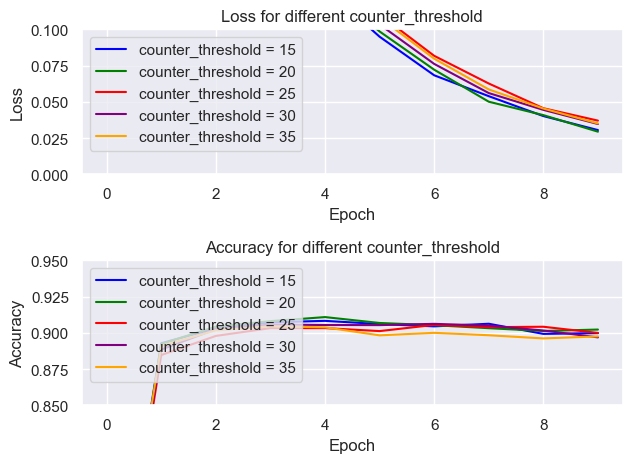

In [32]:
path = r'E:\Iliushina_files\DLS\2_part\2. text classification\counter_threshold_affect2.csv'
name = 'counter_threshold'
y_lim_low_loss = 0
y_lim_high_loss = 0.1
y_lim_low_acc = 0.85
y_lim_high_acc = 0.95
plotloss_acc_csv(path, name, y_lim_low_loss, y_lim_high_loss, y_lim_low_acc, y_lim_high_acc)

изменение размера словаря за счет изменения counter_threshold не принесло никаких результатов и можно в дальнейших экспериментах counter_threshold= 20

##### Изменение hidden_dim

In [34]:
hidden_dim_arr = [32, 64, 128, 256, 512, 1024]

#ВЫБОР ГИПЕР-ПАРАМЕТРОВ
batch_size = 512 #оптимально для обучения
num_epoch = 10
num_layers = 1
hidden_dim = 256
dropout_rate = 0.1
#ВЫБОР ГИПЕР-ПАРАМЕТРОВ
aggregation_type = 'mean'
counter_threshold = 15

csv_name = 'hidden_dim_affect2.csv'
feature_name = 'hidden_dim'

df = pd.DataFrame(columns=['model_params(num_epoch, num_layers, hidden_dim, dropout_rate)', feature_name, 'best accuracy', 'loss_v', 'acc_v'])


for hidden_dim in hidden_dim_arr:
    feature_value = hidden_dim
    print('hidden_dim', hidden_dim)

    train_dataloader, eval_dataloader, word2ind, ind2word, vocab = get_data(counter_threshold, words)
    eval_steps = len(train_dataloader) // 2

    model = CharLM_custom(hidden_dim=hidden_dim, vocab_size=len(vocab), dropout_rate = dropout_rate, 
            num_layers = num_layers, aggregation_type=aggregation_type, rnn_type='GRU', 
            bidirectional=False, use_last_token=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

    
    losses, acc = train_loop(model, eval_steps, num_epoch, train_dataloader, eval_dataloader, criterion, optimizer)
    print('Лучшая accuracy:',round(max(acc),3) * 100)
    print('Минимальный loss:',round(min(losses),3))

    save_csv(csv_name, feature_name, feature_value, df, num_epoch, num_layers, hidden_dim, dropout_rate, acc, losses)
    print('-------------')
    del model
    torch.cuda.empty_cache()

hidden_dim 32
Размер словаря: 15764


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 89.60000000000001
Минимальный loss: 0.219
-------------
hidden_dim 64
Размер словаря: 15764


C:\Users\Anna\AppData\Local\Temp\ipykernel_6496\3335776643.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 90.10000000000001
Минимальный loss: 0.153
-------------
hidden_dim 128
Размер словаря: 15764


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 90.60000000000001
Минимальный loss: 0.082
-------------
hidden_dim 256
Размер словаря: 15764


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 90.7
Минимальный loss: 0.032
-------------
hidden_dim 512
Размер словаря: 15764


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 91.4
Минимальный loss: 0.018
-------------
hidden_dim 1024
Размер словаря: 15764


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 91.3
Минимальный loss: 0.019
-------------


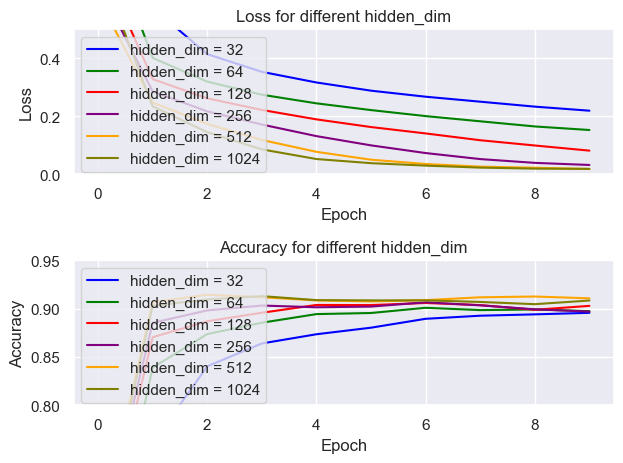

In [37]:
path = r'E:\Iliushina_files\DLS\2_part\2. text classification\hidden_dim_affect2.csv'
name = 'hidden_dim'
y_lim_low_loss = 0
y_lim_high_loss = 0.5
y_lim_low_acc = 0.8
y_lim_high_acc = 0.95
plotloss_acc_csv(path, name, y_lim_low_loss, y_lim_high_loss, y_lim_low_acc, y_lim_high_acc)

Размер скрытого слоя оказывает большее значение на точность, чем больше hidden_dim, тем выше точность. Однако при значениях 512 и 1024 разница уже не столь ощутима. Учитывя, что вычисления с hidden_dim=1024 занимают значительно больше времени, оптимальный hidden_dim=512.

In [44]:
dropout_rate_arr = [0.1, 0.2, 0.25, 0.3]

#ВЫБОР ГИПЕР-ПАРАМЕТРОВ
batch_size = 512 #оптимально для обучения
num_epoch = 10
num_layers = 1
hidden_dim = 256
aggregation_type = 'mean'
counter_threshold = 20
lr = 0.001


csv_name = 'dropout_rate_affect2.csv'
feature_name = 'dropout_rate'

df = pd.DataFrame(columns=['model_params(num_epoch, num_layers, hidden_dim, dropout_rate)', feature_name, 'best accuracy', 'loss_v', 'acc_v'])

for dropout_rate in dropout_rate_arr:
    
    feature_value = dropout_rate
    print('dropout_rate', dropout_rate)
    train_dataloader, eval_dataloader, word2ind, ind2word, vocab = get_data(counter_threshold, words)
    eval_steps = len(train_dataloader) // 2

    model = CharLM_custom(hidden_dim=hidden_dim, vocab_size=len(vocab), dropout_rate = dropout_rate, 
            num_layers = num_layers, aggregation_type=aggregation_type, rnn_type='LSTM', 
            bidirectional=True, use_last_token=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    
    losses, acc = train_loop(model, eval_steps, num_epoch, train_dataloader, eval_dataloader, criterion, optimizer)
    print('Лучшая accuracy:',round(max(acc),3) * 100)
    print('Минимальный loss:',round(min(losses),2))

    df = save_csv(csv_name, feature_name, feature_value, df, num_epoch, num_layers, hidden_dim, dropout_rate, acc, losses)
    print('-------------')
    del model
    torch.cuda.empty_cache()

dropout_rate 0.1
Размер словаря: 13403


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 90.3
Минимальный loss: 0.03
-------------
dropout_rate 0.2
Размер словаря: 13403


C:\Users\Anna\AppData\Local\Temp\ipykernel_15888\1426074773.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 90.60000000000001
Минимальный loss: 0.03
-------------
dropout_rate 0.25
Размер словаря: 13403


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 90.5
Минимальный loss: 0.03
-------------
dropout_rate 0.3
Размер словаря: 13403


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 90.3
Минимальный loss: 0.03
-------------


Best accurcy: 0.9031999707221985


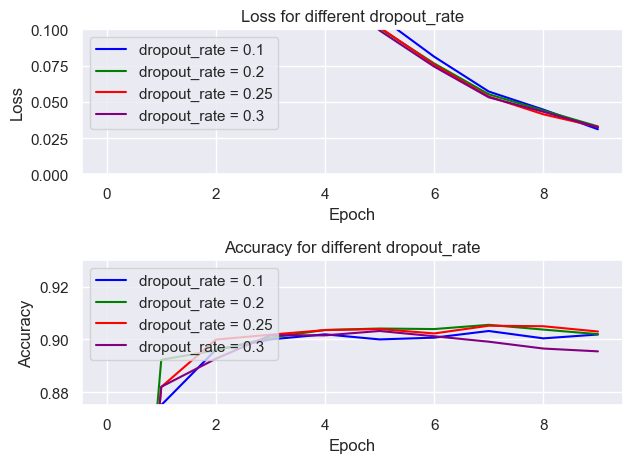

In [48]:
path = r'E:\Iliushina_files\DLS\2_part\2. text classification\dropout_rate_affect2.csv'
name = 'dropout_rate'
y_lim_low_loss = 0
y_lim_high_loss = 0.1
y_lim_low_acc = 0.875
y_lim_high_acc = 0.93
plotloss_acc_csv(path, name, y_lim_low_loss, y_lim_high_loss, y_lim_low_acc, y_lim_high_acc)

По результатам видно, что dropout_rate =20% является оптимальным параметром. При увечении этого параметра качество ухудшается

##### Изменение num_layers

In [30]:
num_layers_arr = list(range(1, 6))

#ВЫБОР ГИПЕР-ПАРАМЕТРОВ
batch_size = 512 #оптимально для обучения
num_epoch = 8
hidden_dim = 256
dropout_rate = 0.1
aggregation_type = 'mean'

csv_name = 'num_layers_affect2.csv'
feature_name = 'num_layers'

df = pd.DataFrame(columns=['model_params(num_epoch, num_layers, hidden_dim, dropout_rate)', feature_name, 'best accuracy', 'loss_v', 'acc_v'])

for num_layers in num_layers_arr:
    feature_value = num_layers
    print('num_layers', num_layers)

    train_dataloader, eval_dataloader, word2ind, ind2word, vocab = get_data(counter_threshold, words)
    eval_steps = len(train_dataloader) // 2

    model = CharLM_custom(hidden_dim=hidden_dim, vocab_size=len(vocab), dropout_rate = dropout_rate, 
            num_layers = num_layers, aggregation_type=aggregation_type, rnn_type='GRU', 
            bidirectional=False, use_last_token=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    
    losses, acc = train_loop(model, eval_steps, num_epoch, train_dataloader, eval_dataloader, criterion, optimizer)
    print('Лучшая accuracy:',round(max(acc),3) * 100)
    print('Минимальный loss:',round(min(losses),2))

    df = save_csv(csv_name, feature_name, feature_value, df, num_epoch, num_layers, hidden_dim, dropout_rate, acc, losses)
    print('-------------')
    del model
    torch.cuda.empty_cache()

num_layers 1
Размер словаря: 13403


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 90.5
Минимальный loss: 0.06
-------------
num_layers 2
Размер словаря: 13403


C:\Users\Anna\AppData\Local\Temp\ipykernel_19056\1426074773.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 91.0
Минимальный loss: 0.06
-------------
num_layers 3
Размер словаря: 13403


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 90.8
Минимальный loss: 0.07
-------------
num_layers 4
Размер словаря: 13403


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Best accurcy: 0.9045999844868978


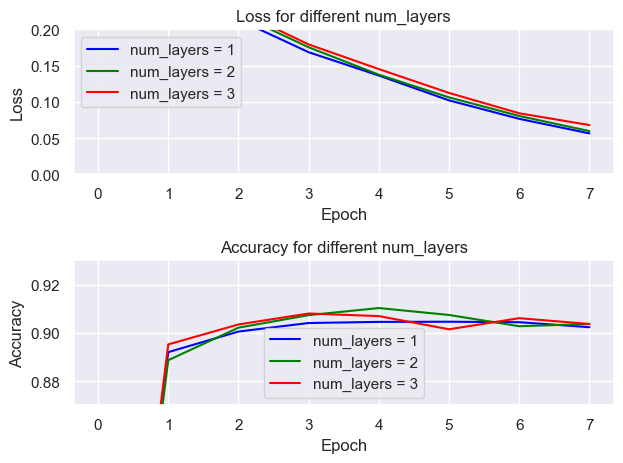

In [22]:
path = r'E:\Iliushina_files\DLS\2_part\2. text classification\num_layers_affect2.csv'
name = 'num_layers'
y_lim_low_loss = 0
y_lim_high_loss = 0.2
y_lim_low_acc = 0.87
y_lim_high_acc = 0.93
plotloss_acc_csv(path, name, y_lim_low_loss, y_lim_high_loss, y_lim_low_acc, y_lim_high_acc)

Увеличение кол-ва реккурентных слоев ухудшило качество модели. Оптимальное значение num_layers=2

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

В ходе работы было проанализированы средующие параметры и их влияние: aggregation_type, rnn_type, bidirectional, use_last_token, hidden_dim, num_layers, dropout_rate, counter_threshold.

Были сделаны следующие выводы:

* Двунаправленность улучшила результат, также как и использование эмбединга последнего токена. По графикам видно, что если не использовать use_last_token, то сходимость ухудшается. Агрегация эмбедингов простым усреднением показывает лучшие результаты, чем max pooling.
* Колебания в зависимости от эпохи присутвуют и лучше всего с ней справляется LSTM. 
* При комбинировании hidden_dim = 512 и bidirectional=True, use_last_token=True, обучение становится слишком долгим и невозможно провести полностью тренировку
* dropout_rate, counter_threshold, num_layers не сильно прияют на качество модели, однако среди них тоже были выбраны оптимальные значения. 
* Оптимальная модель дростигла точности 91.4%: CharLM_custom(hidden_dim=512, vocab_size = 13403, dropout_rate = 0.2, 
        num_layers = 2, aggregation_type='mean', rnn_type='GRU', 
        bidirectional=False, use_last_token=True )

In [21]:
num_layers = 2
batch_size = 512 #оптимально для обучения
num_epoch = 8
hidden_dim = 512
dropout_rate = 0.2
aggregation_type = 'mean'
lr = 0.001
counter_threshold = 20

train_dataloader, eval_dataloader, word2ind, ind2word, vocab = get_data(counter_threshold, words)
eval_steps = len(train_dataloader) // 2

model = CharLM_custom(hidden_dim=hidden_dim, vocab_size=len(vocab), dropout_rate = dropout_rate, 
        num_layers = num_layers, aggregation_type=aggregation_type, rnn_type='LSTM', 
        bidirectional=False, use_last_token=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

losses, acc = train_loop(model, eval_steps, num_epoch, train_dataloader, eval_dataloader, criterion, optimizer)
print('Лучшая accuracy:',round(max(acc),3) * 100)
print('Минимальный loss:',round(min(losses),2))

Размер словаря: 13403


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/235 [00:00<?, ?it/s]

Лучшая accuracy: 91.2
Минимальный loss: 0.03


Лучшая accuracy: 91.18


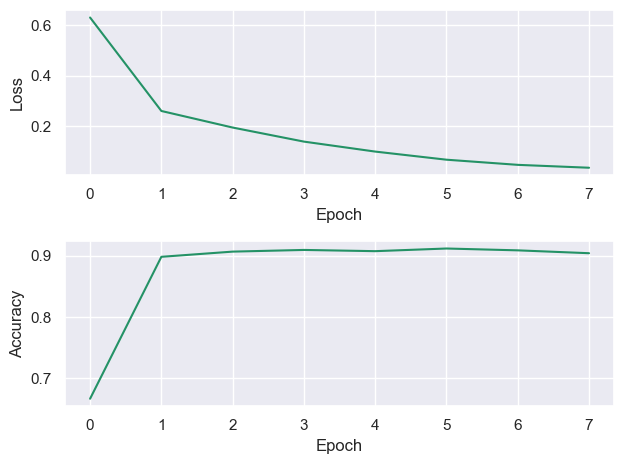

In [22]:
plot_loss_acc(losses, acc)

Лучшая accuracy: 90.93


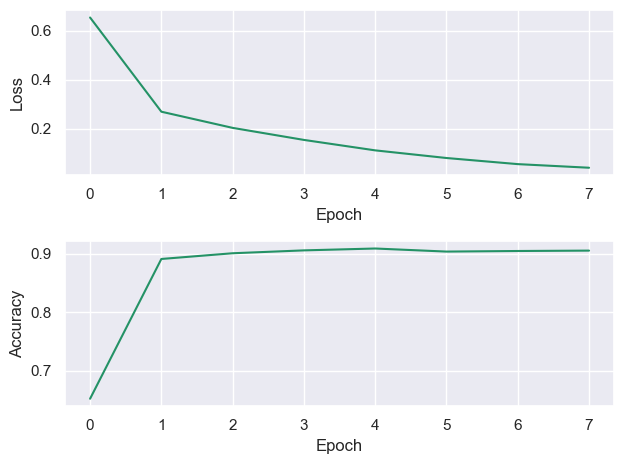

In [19]:
plot_loss_acc(losses, acc)

In [26]:
num_layers = 2
batch_size = 512 #оптимально для обучения
num_epoch = 8
hidden_dim = 512
dropout_rate = 0.2
aggregation_type = 'mean'
lr = 0.001
counter_threshold = 20

train_dataloader, eval_dataloader, word2ind, ind2word, vocab = get_data(counter_threshold, words)
eval_steps = len(train_dataloader) // 2

model = CharLM_custom(hidden_dim=hidden_dim, vocab_size=len(vocab), dropout_rate = dropout_rate, 
        num_layers = num_layers, aggregation_type=aggregation_type, rnn_type='GRU', 
        bidirectional=False, use_last_token=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

losses, acc = train_loop(model, eval_steps, num_epoch, train_dataloader, eval_dataloader, criterion, optimizer)
print('Лучшая accuracy:',round(max(acc),3) * 100)
print('Минимальный loss:',round(min(losses),2))

Размер словаря: 13403


Training epoch 0::   0%|          | 0/235 [00:00<?, ?it/s]

KeyboardInterrupt: 

Лучшая accuracy: 91.4


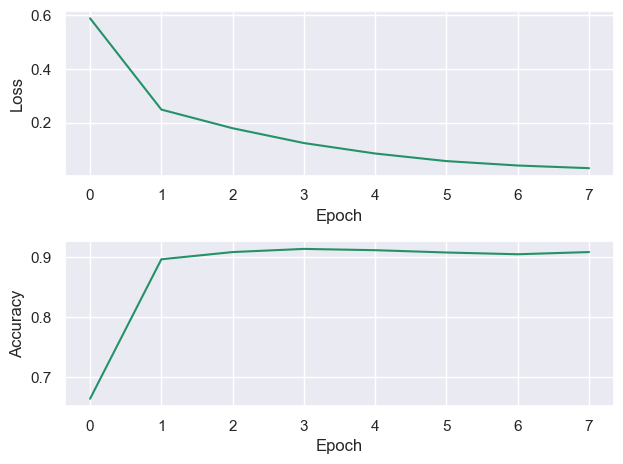

In [27]:
plot_loss_acc(losses, acc)